In [1]:
import utils.eigenstate_generator as eig
import utils.cs_vqe as c
import utils.cs_vqe_ansatz as c_anz
import utils.qubit_conversion as qonvert
import ast
import matplotlib
import matplotlib.pyplot as plt
from openfermion.linalg import LinearQubitOperator

In [2]:
f = open("hamiltonians.txt","r")
hamiltonians = ast.literal_eval(f.read())
f.close()

speciesname = 'H2-O1_STO-3G_singlet'

encoding = hamiltonians[speciesname][0] # in this dataset, always 'JW' for Jordan-Wigner, but leaves room for trying Bravyi-Kitaev as well
num_qubits = hamiltonians[speciesname][1] # number of qubits (all of these Hamiltonians have been tapered for molecular symmetries)
ham = hamiltonians[speciesname][2] # full Hamiltonian
ham_noncon = hamiltonians[speciesname][3] # noncontextual part of Hamiltonian, found by greedy DFS
true_gs = hamiltonians[speciesname][4] # ground state energy of full Hamiltonian (in Hartree)
gs_noncon = hamiltonians[speciesname][5] # list containing information about noncontextual ground state: zeroth entry is ground state energy of noncontextual part of Hamiltonian

print('number of qubits:', num_qubits)
print('true ground state energy:', true_gs)
print('noncontextual approximation to ground state energy:', gs_noncon[0])

number of qubits: 10
true ground state energy: -83.92870248174707
noncontextual approximation to ground state energy: -83.87422390061549


In [3]:
model = c.quasi_model(ham_noncon)
fn_form = c.energy_function_form(ham_noncon, model)
gs_noncon = c.find_gs_noncon(ham_noncon)
gs_noncon_energy = gs_noncon[0]
ep_state = gs_noncon[1]
ham_context = {p:c for p,c in ham.items() if p not in ham_noncon}

In [4]:
print('commuting generators:',model[0], '\n')
print('anticommuting generators:',model[1], '\n')
print('Minimising configuration:', gs_noncon[1])

commuting generators: ['ZIIIIIIIII', 'IZIIIIIIII', 'IIZIIIIIII', 'IIIZIIIIII', 'IIIIZIIIII', 'IIIIIIZIII', 'IIIIIIIZII', 'IIIIIIIIZI', 'IIIIIIIIIZ'] 

anticommuting generators: ['IIIIZXZZZZ', 'IIIIIZIIII'] 

Minimising configuration: [[1, -1, -1, -1, -1, -1, -1, -1, -1], [9.576858245891391e-08, -0.9999999999999954]]


In [5]:
A = {p:ep_state[1][index] for index, p in enumerate(model[1])}
r1 = ep_state[1][0]
r2 = ep_state[1][1]
print('Observable A:', A)

Observable A: {'IIIIZXZZZZ': 9.576858245891391e-08, 'IIIIIZIIII': -0.9999999999999954}


In [6]:
c_anz.epistemic_dist(ep_state)

{(1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1): 1.1379787092233828e-15,
 (1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1): 0.5000000478842901,
 (1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1): 1.137978491258188e-15,
 (1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1): 0.49999995211570764}

In [7]:
generators = model[0]
print(generators)

['ZIIIIIIIII', 'IZIIIIIIII', 'IIZIIIIIII', 'IIIZIIIIII', 'IIIIZIIIII', 'IIIIIIZIII', 'IIIIIIIZII', 'IIIIIIIIZI', 'IIIIIIIIIZ']


In [8]:
ham_q = qonvert.dict_to_QubitOperator(ham, num_qubits)
ham_noncon_q = qonvert.dict_to_QubitOperator(ham_noncon, num_qubits)
ham_context_q = qonvert.dict_to_QubitOperator(ham_context, num_qubits)

#take expectation value algebraically
psi = eig.add_eigenstate(molecule='H2O', r1=r1, r2=r2, index=495, theta=0, num_qubits=num_qubits)
expect = eig.expectation(ham_q, psi, num_qubits)

print('<H> w.r.t. simultaneous eigenstate:', expect)
print('Noncontextual approximation:', gs_noncon_energy)
print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match?

<H> w.r.t. simultaneous eigenstate: (-83.87422390061549+0j)
Noncontextual approximation: -83.87422390061549
Expectation values match? True


['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIZIIIII', 'IIIZIIIIII', 'IIZIIIIIII', 'IZIIIIIIII', 'ZIIIIIIIII'] [9, 8, 7, 6, 4, 3, 2, 1, 0]
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512
512 512


/home/tim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/tim/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIZIIIII', 'IIIZIIIIII', 'IIZIIIIIII', 'IZIIIIIIII'] [9, 8, 7, 6, 4, 3, 2, 1]
256 256
256 256
256 256
256 256
256 256
256 256
256 256
256 256
256 256
256 256
256 256
256 256
256 256
256 256
256 256
256 256
256 256
256 256
256 256
256 256
['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIZIIIII', 'IIIZIIIIII', 'IIZIIIIIII'] [9, 8, 7, 6, 4, 3, 2]
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
128 128
['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIZIIIII', 'IIIZIIIIII'] [9, 8, 7, 6, 4, 3]
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
64 64
['IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIZII', 'IIIIIIZIII', 'IIIIZIIIII'] [9, 8, 7, 6, 4]
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32 32
32

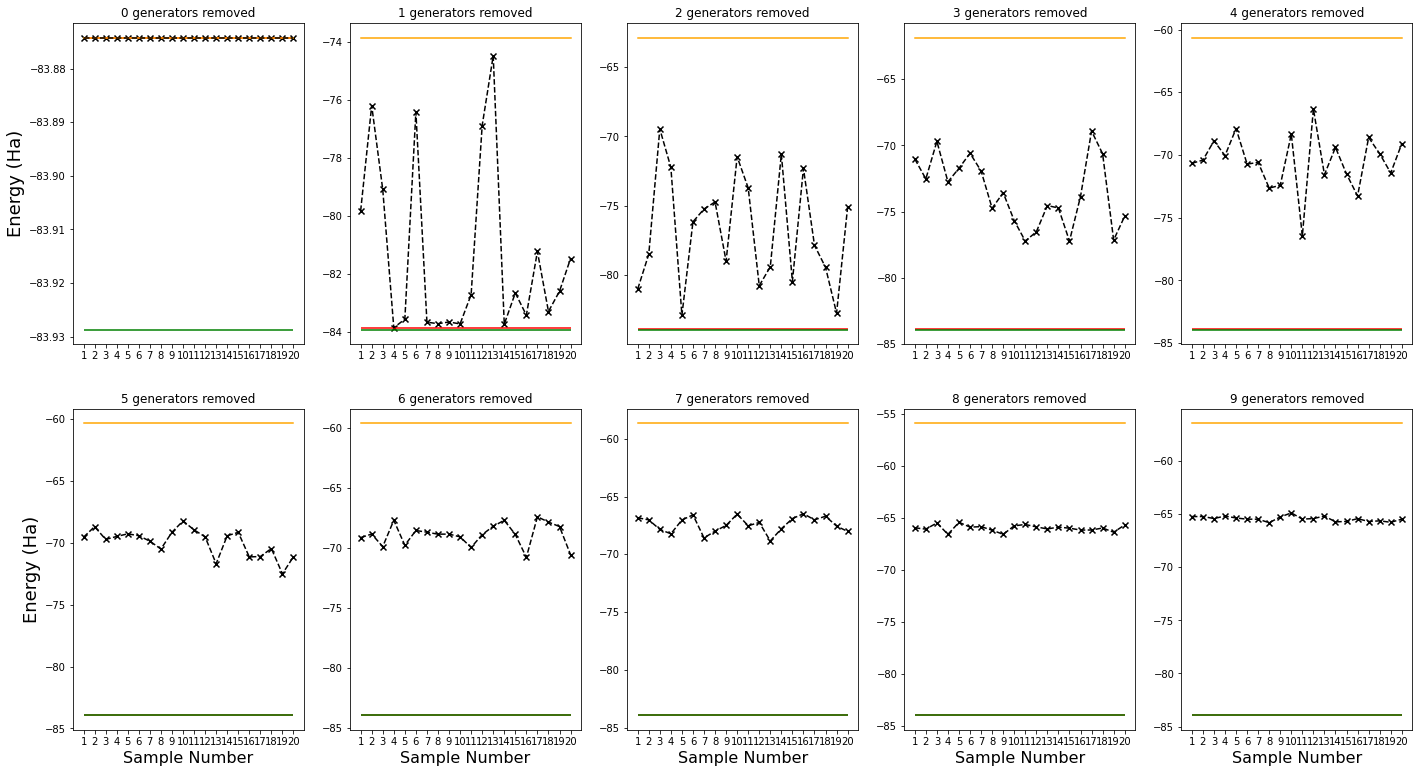

In [9]:
#take expectation value algebraically
from matplotlib import pyplot as plt
molecule='H2O'
shots=20
initial_state = '0111101111'

fig, axs = plt.subplots(nrows = 2, ncols = 5, figsize = (24,13))
grid_pos = [(0,0),(0,1),(0,2),(0,3),(0,4),(1,0),(1,1),(1,2),(1,3),(1,4)]
grid_pos.reverse()

X=list(range(1, shots+1))

for index, grid in enumerate(grid_pos):
    
    removed_index = list(range(index, 9))
    removed_index.reverse()
    removed_generators = [generators[i] for i in removed_index]
    Z_indices = [g.find('Z') for g in removed_generators]
    print(removed_generators, Z_indices)
    
    new_ham_noncon, new_ham_context = eig.discard_generator(ham_noncon, ham_context, removed_generators)
    new_ham_noncon_q = qonvert.dict_to_QubitOperator(new_ham_noncon, num_qubits)
    new_ham_context_q = qonvert.dict_to_QubitOperator(new_ham_context, num_qubits)

    random_amplitudes=[]
    for i in range(shots):  
        rand_vec = eig.random_vector(2**len(removed_index))
        rand_vec = sorted([eig.random_complex_unit()*c for c in rand_vec], key=abs)
        rand_vec.reverse()
        random_amplitudes.append(rand_vec)

    #amps=[random_vector(len(eigenstate_indices)) for i in range(shots)]
    Y_noncon=[]
    Y_context=[]
    Y_combined=[]
    Y_full=[]

    #A_op = QubitOperator('Y0 Z1 Z2 Z3 Z4 Z5 Y6 Z7', r1) + QubitOperator('Z6', r2)
    #A = LinearQubitOperator(A_op, num_qubits)

    for amps in random_amplitudes:
        expect_noncon, expect_context = eig.expectation_optimiser(molecule=molecule, ham_n=new_ham_noncon_q, ham_c=new_ham_context_q, 
                                                                  r1=r1, r2=r2, amps=amps, initial_state=initial_state,num_qubits=num_qubits,
                                                                  Z_indices=Z_indices)

        #Y_full.append(expect_full)
        Y_noncon.append(expect_noncon)
        Y_context.append(expect_context)
        Y_combined.append(expect_noncon+expect_context)

        #print(p, expect_noncon + expect_context < gs_noncon_energy)
        #print((np.conjugate(psi)).dot(psi))
        #Verify +1-eigenstate
        #A_psi = A.matvec(psi)
        #print(psi_conj.dot(A_psi))
    
    axs[grid].plot(X, Y_noncon, color='orange')
    #axs[grid].scatter(X, Y_context, color='blue', marker = 'x')
    #axs[grid].plot(X, Y_context, color='blue', ls='--')
    axs[grid].scatter(X, Y_combined, color='black', marker = 'x')
    axs[grid].plot(X, Y_combined, color='black', ls='--')
    #plt.plot(range(shots), Y_combined, color='purple')
    axs[grid].hlines(gs_noncon_energy, 1, shots, color='r')
    axs[grid].hlines(true_gs, 1, shots, color='g')
    
    axs[grid].set_xticks(X)
    axs[grid].set_title("%i generators removed" % abs(index-9))
    if grid[0] == 1:
        axs[grid].set_xlabel('Sample Number',fontsize=16)
    if grid[1] == 0:
        axs[grid].set_ylabel('Energy (Ha)',fontsize=18)
    #print('<H> w.r.t. simultaneous eigenstate:', expect)
    #print('Noncontextual approximation:', gs_noncon_energy)
    #print('Expectation values match?', abs(expect - gs_noncon_energy) < 10**-12) #sanity check - expectation values match? 